<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/Autoencoder-demo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder - 01418496 (หมู่เรียน 200)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
tf.__version__

'2.18.0'

In [ ]:
import numpy as np
from PIL import Image

### Setting to execute on Processor (GPU or CPU)

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on CPU


### Download Dataset

In [ ]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("tongpython/cat-and-dog/version/1")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing


In [ ]:
dataset_path = "./dataset"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Path: {dirpath}, Subdirectories: {dirnames}, Files: {len(filenames)}")

Path: ./dataset, Subdirectories: ['test_set', 'training_set'], Files: 0
Path: ./dataset\test_set, Subdirectories: ['test_set'], Files: 0
Path: ./dataset\test_set\test_set, Subdirectories: ['cats', 'dogs'], Files: 0
Path: ./dataset\test_set\test_set\cats, Subdirectories: [], Files: 1012
Path: ./dataset\test_set\test_set\dogs, Subdirectories: [], Files: 1013
Path: ./dataset\training_set, Subdirectories: ['training_set'], Files: 0
Path: ./dataset\training_set\training_set, Subdirectories: ['cats', 'dogs'], Files: 0
Path: ./dataset\training_set\training_set\cats, Subdirectories: [], Files: 4001
Path: ./dataset\training_set\training_set\dogs, Subdirectories: [], Files: 4006


In [ ]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0  # Normalize pixel values to [0, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    return imgs

def to_image(img):
    img = np.squeeze(img)
    return Image.fromarray(np.uint8(img * 255))

In [ ]:
import cv2
def dataset_to_numpy_and_preprocess(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    imgs = np.concatenate(images)
    lbls = np.concatenate(labels)
    return preprocess(imgs), lbls

def change_gray_images(images):
    gray_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(image)

    gray_images = np.array(gray_images)
    gray_images = np.repeat(gray_images[:, :, :, np.newaxis], 3, axis=3)  # Repeat across the 3rd axis
    return gray_images

In [ ]:
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(50, 50),  # Resize images
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(50, 50),
    batch_size=32,
)

X_train, y_train = dataset_to_numpy_and_preprocess(train_dataset)
X_test, y_test = dataset_to_numpy_and_preprocess(test_dataset)
X_train_gray = change_gray_images(X_train)
X_test_gray = change_gray_images(X_test)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
SHAPE = X_train.shape[1:]
print(f"Shape: {SHAPE}")

X_train shape: (8005, 104, 104, 3)
y_train shape: (8005,)
X_test shape: (2023, 104, 104, 3)
y_test shape: (2023,)
Shape: (104, 104, 3)


In [ ]:
print(f"X_train_gray: {X_train_gray.shape}")
print(f"X_test_gray: {X_test_gray.shape}")
NEW_SHAPE = X_train_gray.shape[1:]
print(f"New Shape: {NEW_SHAPE}")

X_train_gray: (8005, 104, 104, 3)
X_test_gray: (2023, 104, 104, 3)
New Shape: (104, 104, 3)


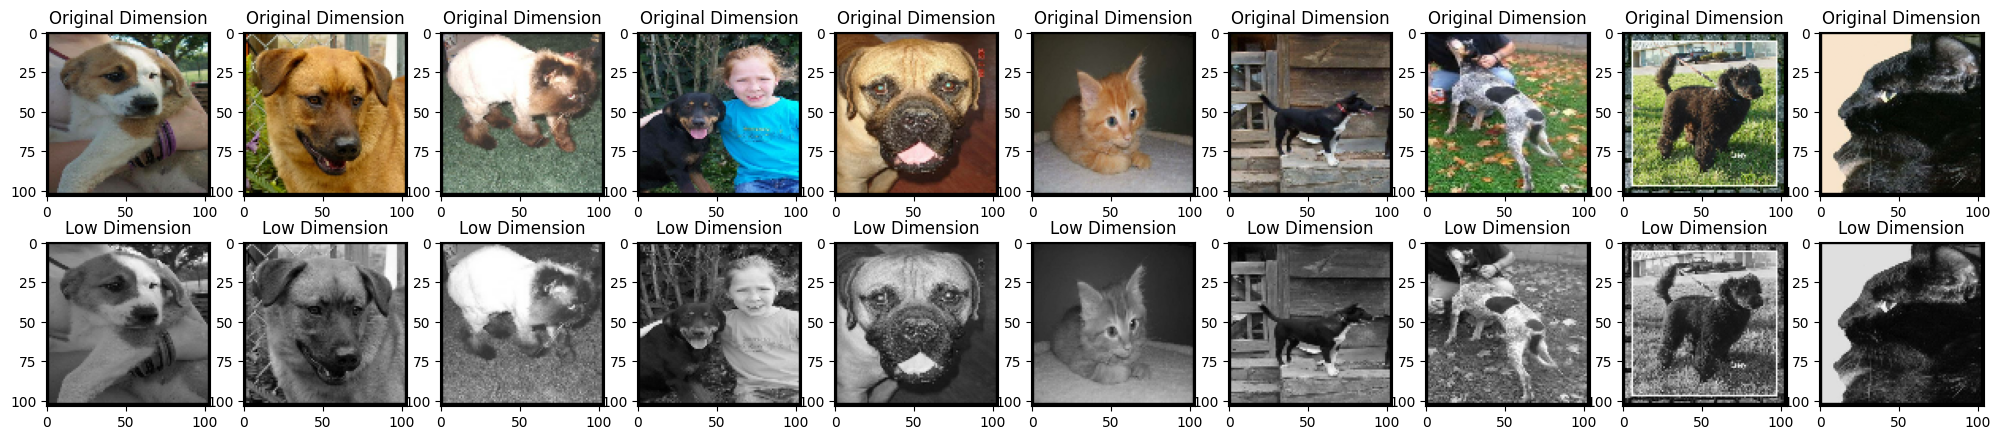

In [ ]:
num_images = 10
fig = plt.figure(figsize=(25, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i])
    plt.title("Original Dimension")

    plt.subplot(2, 10, i+1+num_images)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title("Low Dimension")

### Create Model by using OOP

In [ ]:
from tensorflow.keras import Model, layers, losses, activations, optimizers

class Autoencoder(Model):
  def __init__(self, latent_dim:int, shape:tuple):
    super(Autoencoder, self).__init__()
    self.shape = shape
    self.latent_dim = latent_dim

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=SHAPE, name="Encoder_Input"),
      layers.Conv2D(filters=52, kernel_size=(3, 3), padding='same', activation=activations.relu),
      layers.Conv2D(filters=21, kernel_size=(3, 3), padding='same', activation=activations.relu),
      layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation=activations.relu),
      layers.Flatten(),
      layers.Dense(latent_dim)
    ])


    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(latent_dim,)),
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation=activations.relu),
      layers.Reshape(shape),
      layers.Conv2DTranspose(filters=10, kernel_size=(3, 3), padding='same', activation=activations.relu),
      layers.Conv2DTranspose(filters=21, kernel_size=(3, 3), padding='same', activation=activations.relu),
      layers.Conv2DTranspose(filters=52, kernel_size=(3, 3), padding='same', activation=activations.relu),
      layers.Conv2D(filters=shape[-1], kernel_size=(3, 3), padding='same', activation=activations.sigmoid)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder = Autoencoder(5, SHAPE)

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 104, 104, 52)   │         1,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 104, 104, 21)   │         9,849 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 104, 104, 10)   │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 108160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │       540,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,010 (2.11 MB)

 Trainable params: 554,010 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 32448)          │       194,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 104, 104, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 104, 104, 10)   │           280 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 104, 104, 21)   │         1,911 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 104, 104, 52)   │         9,880 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 104, 104, 3)    │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,166 (813.15 KB)

 Trainable params: 208,166 (813.15 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(X_train_gray, X_train, epochs=10, validation_data=(X_test, X_test), batch_size=32)

Epoch 1/10
 39/251 ━━━━━━━━━━━━━━━━━━━━ 55s 260ms/step - loss: 0.0825

KeyboardInterrupt: 

In [ ]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 104, 104, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 104, 104, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │       259,587 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,995 (1015.61 KB)

 Trainable params: 259,995 (1015.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 32448)          │       129,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 104, 104, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 104, 104, 8)    │           224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 104, 104, 4)    │           292 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 3)    │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,419 (509.45 KB)

 Trainable params: 130,419 (509.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
encoded_imgs = autoencoder.encoder(X_test_gray)
decoded_imgs = autoencoder.decoder(encoded_imgs)

In [ ]:
prediction = autoencoder.predict(X_test_gray)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


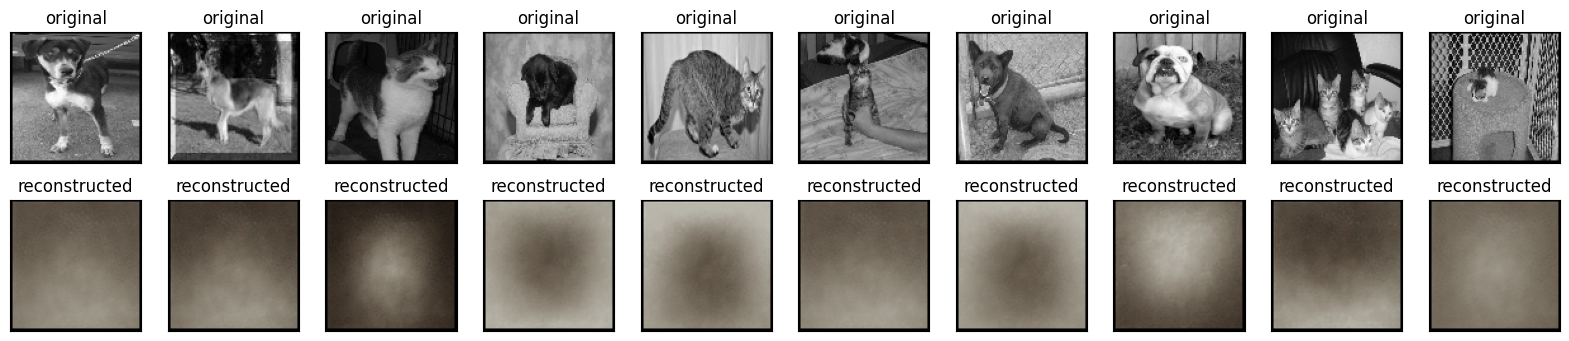

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_gray[i])
    plt.title("original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(prediction[i])
    plt.title("reconstructed")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

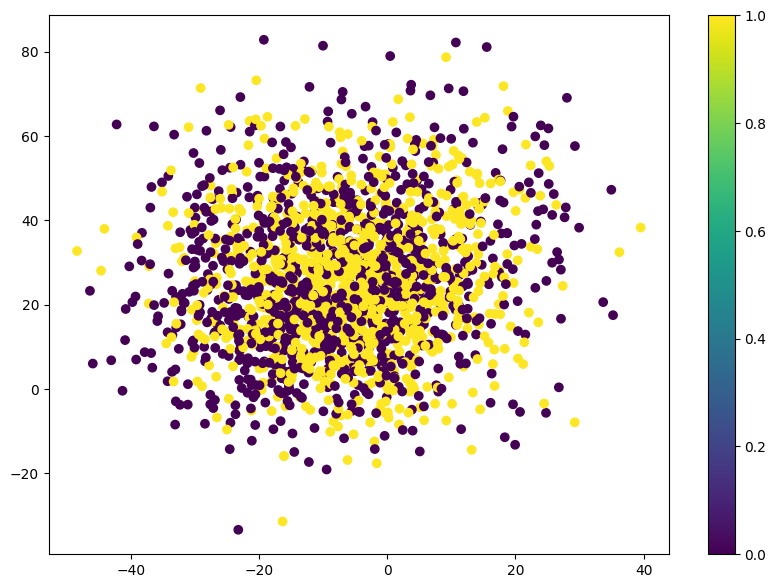

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
plt.colorbar()
plt.show()